Install `xlrd` for reading the `xls` file

In [21]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [22]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [23]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))  # Adjust the path as needed

from my_util import df_to_corr_matrix

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from joblib import Parallel, delayed

from pickle import dump , load

import warnings

### Read the data and load the selected features

In [24]:
NUM_OF_SELECTED_FEATURES = 25

data = pd.read_excel(training_file)
data.replace(999, np.nan, inplace=True)

data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data.dropna(subset=["pCR (outcome)"], inplace=True)

with open(f'../FeatureSelection/pkl/{NUM_OF_SELECTED_FEATURES}_selected_features.pkl', mode='rb') as file:
    selected_features = load(file)
    print(f"Loaded '{file.name}' to selected_feature")

X = data[selected_features]
y = data["pCR (outcome)"]
print(X.shape, y.shape)

Loaded '../FeatureSelection/pkl/25_selected_features.pkl' to selected_feature
(395, 25) (395,)


### Split the data into train_full and test_reserved (untouch)

In [25]:
# Close ratio random_state
# [14, 47, 49, 52, 62, 76, 83, 89, 92, 116, 118, 122, 136, 138, 144, 146, 150, 156, 157, 159, 170, 172, 174, 185]

while True:  
    X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=14) # similar distribution of 1 and 0
    # X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=None)

    X_train_full.reset_index(drop=True, inplace=True)
    X_test_reserved.reset_index(drop=True, inplace=True)
    y_train_full.reset_index(drop=True, inplace=True)
    y_test_reserved.reset_index(drop=True, inplace=True)

    ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
    ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

    if abs(ratio_train - ratio_test) < 0.1:
        break

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")

Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 316 data. The testing data has 79 data. 
Positive ratio: 
	Train: 0.21203
	Test: 0.21519


### KNNImputer

In [27]:
n_neighbors = 11

imputer = KNNImputer(n_neighbors=n_neighbors)
X_train_full = pd.DataFrame(imputer.fit_transform(X_train_full), columns=X_train_full.columns)
print("Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.")
print(X_train_full.shape, y_train_full.shape)

with open("pkl/imputer.pkl", 'wb') as file:
    dump(imputer, file)
    print(f"Saved imputer to '{file.name}'")

Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.
(316, 25) (316,)
Saved imputer to 'pkl/imputer.pkl'


### Normalisation

##### Standardisation

In [28]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


##### Robust Scaler

In [29]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


In [30]:
SCALER = "standard"

In [10]:
# SCALER = "robust"

In [31]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

(25, 25)


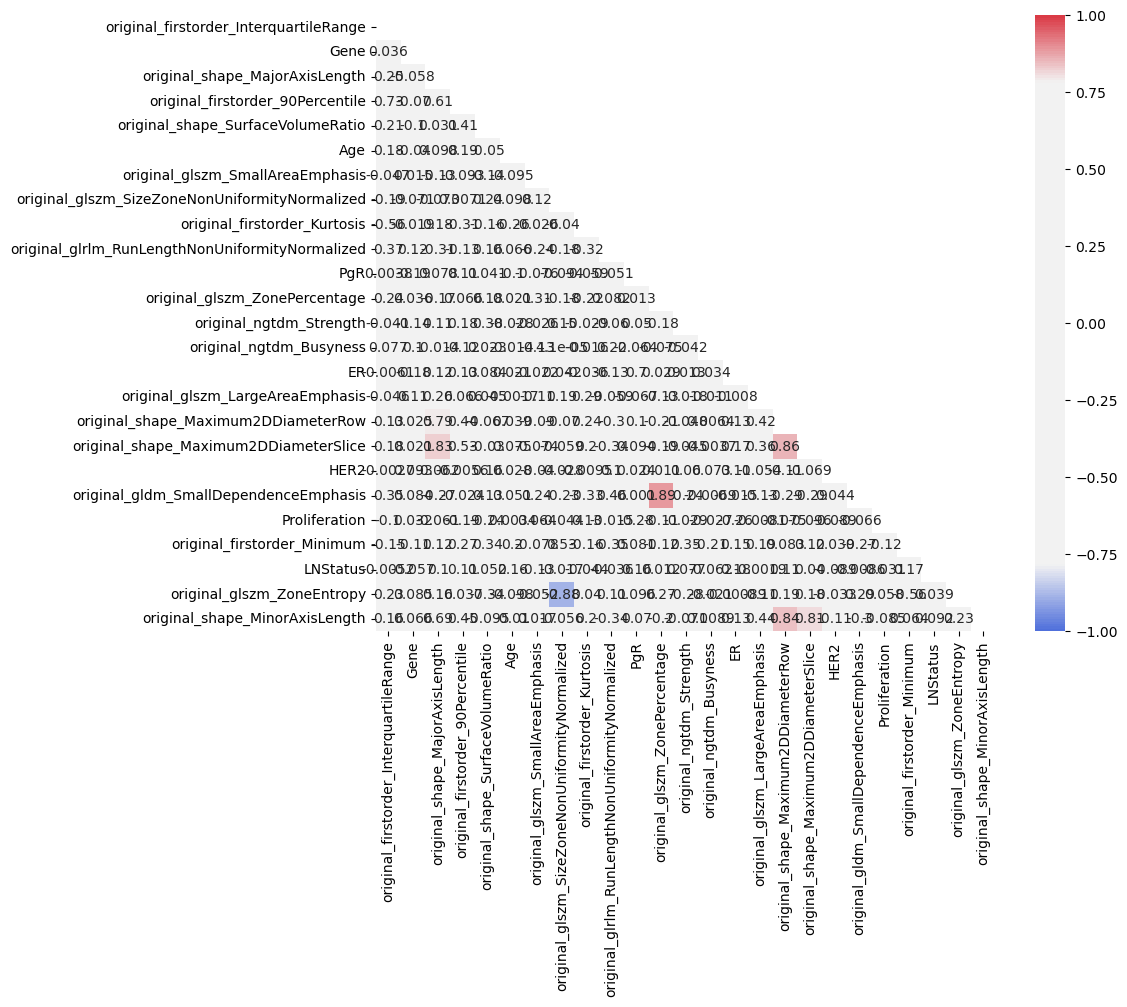

In [32]:
df_to_corr_matrix(Xs)

### IMB Pipeline

In [58]:
pipeline = Pipeline([
  ('pca', PCA()),
  ('sampling', SMOTE()),
  ('tree', DecisionTreeClassifier()),
])

param_grid = {
    'pca__n_components': [9, 11, 13, 14, 15],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__splitter': ['best', 'random'],
    'tree__max_depth': [2, 3, 4, 5, 6],
    'tree__min_samples_split': [2, 5, 10, 15, 30],
    'tree__min_samples_leaf': [2, 4, 6, 8, 10]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring=['f1', 'recall'], cv=5, verbose=1, 
                           n_jobs=-1, return_train_score=True, refit='f1')

# Fit the model
grid_search.fit(Xs, y_train_full)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_index = grid_search.best_index_

print(f"Best Parameters at Index {best_index} :", best_params)
print(f"Best {str(grid_search.scorer_).split('(')[1].split(',')[0]} Score:", best_score)

pd.DataFrame(grid_search.cv_results_).to_csv('output.csv')

Fitting 5 folds for each of 3750 candidates, totalling 18750 fits


Best Parameters at Index 2993 : {'pca__n_components': 14, 'tree__criterion': 'log_loss', 'tree__max_depth': 6, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 5, 'tree__splitter': 'random'}
Best f1_score Score: 0.5091406850988733


/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning:

invalid value encountered in cast



In [59]:
results = pd.DataFrame(grid_search.cv_results_)
print(list(results.keys())[4:10])

['param_pca__n_components', 'param_tree__criterion', 'param_tree__max_depth', 'param_tree__min_samples_leaf', 'param_tree__min_samples_split', 'param_tree__splitter']


In [60]:
results = pd.DataFrame(grid_search.cv_results_)

filter = results['mean_train_recall'] == 1
filter = pd.Series([True] * len(results)) # include all data

fig = go.Figure()
# Add mean train score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_f1"][filter]))),
    y=results["mean_train_f1"][filter],
    mode='lines+markers',
    name='Mean Train F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_recall"][filter]))),
    y=results["mean_train_recall"][filter],
    mode='lines+markers',
    name='Mean Train Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
# Add mean test score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_f1"][filter]))),
    y=results["mean_test_f1"][filter],
    mode='lines+markers',
    name='Mean Test F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_recall"][filter]))),
    y=results["mean_test_recall"][filter],
    mode='lines+markers',
    name='Mean Test Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))

# Update layout
fig.update_layout(
    title='Grid Search Mean Train and Test Scores',
    xaxis_title='Parameter Combinations (Index)',
    yaxis_title='Score',
    legend_title='Scores',
    hovermode='closest'
)
fig.show()

In [61]:
with open("pkl/StandardScaler.pkl", "rb") as file:
  scaler = load(file)

with open("pkl/imputer.pkl", "rb") as file:
  imputer = load(file)

model = grid_search.best_estimator_

# print(f"TARGET_NUM_OF_FEATURES: {TARGET_NUM_OF_FEATURES}, scaler: {SCALER}, num_of_features: {num_of_features}")

print(f"Best Parameters at Index {best_index} :", best_params)
print("Best Cross-Validation Score:", best_score)

y_pred = model.predict(Xs)
report = classification_report(y_train_full, y_pred)
cm = confusion_matrix(y_train_full, y_pred)

print("\nTraining set:")
print(report)
print(cm)

X_test = imputer.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print("Untouched testing set:")
print(report)
print(cm)



Best Parameters at Index 2993 : {'pca__n_components': 14, 'tree__criterion': 'log_loss', 'tree__max_depth': 6, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 5, 'tree__splitter': 'random'}
Best Cross-Validation Score: 0.5091406850988733

Training set:
              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83       249
         1.0       0.44      0.64      0.52        67

    accuracy                           0.75       316
   macro avg       0.66      0.71      0.68       316
weighted avg       0.79      0.75      0.77       316

[[194  55]
 [ 24  43]]
Untouched testing set:
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        62
         1.0       0.26      0.41      0.32        17

    accuracy                           0.62        79
   macro avg       0.53      0.54      0.53        79
weighted avg       0.69      0.62      0.65        79

[[42 20]
 [10  7]]
